In [43]:
%matplotlib inline

# 2-electron VMC code for 2dim quantum dot with importance sampling
# Using gaussian rng for new positions and Metropolis- Hastings 
# Added restricted boltzmann machine method for dealing with the wavefunction
# RBM code based heavily off of:
# https://github.com/CompPhysics/ComputationalPhysics2/tree/gh-pages/doc/Programs/BoltzmannMachines/MLcpp/src/CppCode/ob
from math import exp, sqrt
from random import random, seed, normalvariate
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import sys


class RBM:

    def __init__(self, particles, dimensions, hidden, interaction):
        self.NumberParticles = particles
        self.Dimension = dimensions
        self.NumberHidden = hidden

        self.interaction=interaction

        # guess for parameters
        self.a=np.random.normal(loc=0.0, scale=0.001, size=(particles,dimensions))
        self.b=np.random.normal(loc=0.0, scale=0.001, size=(hidden))
        self.w=np.random.normal(loc=0.0, scale=0.001, size=(particles,dimensions,hidden))

# Trial wave function for the 2-electron quantum dot in two dims
    def wf(self, r,a,b,w):
        sigma=1.0
        sig2 = sigma**2
        Psi1 = 0.0
        Psi2 = 1.0
        Q = self.Qfac(r,b,w)
        
        for iq in range(self.NumberParticles):
            for ix in range(self.Dimension):
                Psi1 += (r[iq,ix]-a[iq,ix])**2
                
        for ih in range(self.NumberHidden):
            Psi2 *= (1.0 + np.exp(Q[ih]))
            
        Psi1 = np.exp(-Psi1/(2*sig2))

        return Psi1*Psi2

    # Local energy  for the 2-electron quantum dot in two dims, using analytical local energy
    def LocalEnergy(self, r,a,b,w):
        sigma=1.0
        sig2 = sigma**2
        locenergy = 0.0
        
        Q = self.Qfac(r,b,w)

        for iq in range(self.NumberParticles):
            for ix in range(self.Dimension):
                sum1 = 0.0
                sum2 = 0.0
                for ih in range(self.NumberHidden):
                    sum1 += w[iq,ix,ih]/(1+np.exp(-Q[ih]))
                    sum2 += w[iq,ix,ih]**2 * np.exp(Q[ih]) / (1.0 + np.exp(Q[ih]))**2
        
                dlnpsi1 = -(r[iq,ix] - a[iq,ix]) /sig2 + sum1/sig2
                dlnpsi2 = -1/sig2 + sum2/sig2**2
                locenergy += 0.5*(-dlnpsi1*dlnpsi1 - dlnpsi2 + r[iq,ix]**2)
                
        if(self.interaction==True):
            for iq1 in range(self.NumberParticles):
                for iq2 in range(iq1):
                    distance = 0.0
                    for ix in range(self.Dimension):
                        distance += (r[iq1,ix] - r[iq2,ix])**2
                        
                    locenergy += 1/sqrt(distance)
                    
        return locenergy

    # Derivate of wave function ansatz as function of variational parameters
    def DerivativeWFansatz(self, r,a,b,w):
        
        sigma=1.0
        sig2 = sigma**2
        
        Q = self.Qfac(r,b,w)
        
        WfDer = np.empty((3,),dtype=object)
        WfDer = [np.copy(a),np.copy(b),np.copy(w)]
        
        WfDer[0] = (r-a)/sig2
        WfDer[1] = 1 / (1 + np.exp(-Q))
        
        for ih in range(self.NumberHidden):
            WfDer[2][:,:,ih] = w[:,:,ih] / (sig2*(1+np.exp(-Q[ih])))
                
        return  WfDer

    # Setting up the quantum force for the two-electron quantum dot, recall that it is a vector
    def QuantumForce(self, r,a,b,w):

        sigma=1.0
        sig2 = sigma**2
        
        qforce = np.zeros((self.NumberParticles,self.Dimension), np.double)
        sum1 = np.zeros((self.NumberParticles,self.Dimension), np.double)
        
        Q = self.Qfac(r,b,w)
        
        for ih in range(self.NumberHidden):
            sum1 += w[:,:,ih]/(1+np.exp(-Q[ih]))
        
        qforce = 2*(-(r-a)/sig2 + sum1/sig2)
        
        return qforce
    
    def Qfac(self, r,b,w):
        """
        This is the Q factor used in the RBM wavefunction
        It is used in the computation of the wavefunction and the quantum force
        """
        Q = np.zeros((self.NumberHidden), np.double)
        temp = np.zeros((self.NumberHidden), np.double)
        
        for ih in range(self.NumberHidden):
            temp[ih] = (r*w[:,:,ih]).sum()
            
        Q = b + temp
        
        return Q
    
# Computing the derivative of the energy and the energy 
    def EnergyMinimization(self, a,b,w):

        NumberMCcycles= 10000
        # Parameters in the Fokker-Planck simulation of the quantum force
        D = 0.5
        TimeStep = 0.05
        # positions
        PositionOld = np.zeros((self.NumberParticles,self.Dimension), np.double)
        PositionNew = np.zeros((self.NumberParticles,self.Dimension), np.double)
        # Quantum force
        QuantumForceOld = np.zeros((self.NumberParticles,self.Dimension), np.double)
        QuantumForceNew = np.zeros((self.NumberParticles,self.Dimension), np.double)

        # seed for rng generator 
        seed()
        energy = 0.0
        DeltaE = 0.0

        EnergyDer = np.empty((3,),dtype=object)
        DeltaPsi = np.empty((3,),dtype=object)
        DerivativePsiE = np.empty((3,),dtype=object)
        EnergyDer = [np.copy(a),np.copy(b),np.copy(w)]
        DeltaPsi = [np.copy(a),np.copy(b),np.copy(w)]
        DerivativePsiE = [np.copy(a),np.copy(b),np.copy(w)]
        for i in range(3): EnergyDer[i].fill(0.0)
        for i in range(3): DeltaPsi[i].fill(0.0)
        for i in range(3): DerivativePsiE[i].fill(0.0)

        
        #Initial position
        for i in range(self.NumberParticles):
            for j in range(self.Dimension):
                PositionOld[i,j] = normalvariate(0.0,1.0)*sqrt(TimeStep)
        wfold = self.wf(PositionOld,a,b,w)
        QuantumForceOld = self.QuantumForce(PositionOld,a,b,w)

        #Loop over MC MCcycles
        for MCcycle in range(NumberMCcycles):
            #Trial position moving one particle at the time
            for i in range(self.NumberParticles):
                for j in range(self.Dimension):
                    PositionNew[i,j] = PositionOld[i,j]+normalvariate(0.0,1.0)*sqrt(TimeStep)+\
                                        QuantumForceOld[i,j]*TimeStep*D
                wfnew = self.wf(PositionNew,a,b,w)
                QuantumForceNew = self.QuantumForce(PositionNew,a,b,w)
                
                GreensFunction = 0.0
                for j in range(self.Dimension):
                    GreensFunction += 0.5*(QuantumForceOld[i,j]+QuantumForceNew[i,j])*\
                                        (D*TimeStep*0.5*(QuantumForceOld[i,j]-QuantumForceNew[i,j])-\
                                        PositionNew[i,j]+PositionOld[i,j])
        
                GreensFunction = exp(GreensFunction)
                ProbabilityRatio = GreensFunction*wfnew**2/wfold**2
                #Metropolis-Hastings test to see whether we accept the move
                if random() <= ProbabilityRatio:
                    for j in range(self.Dimension):
                        PositionOld[i,j] = PositionNew[i,j]
                        QuantumForceOld[i,j] = QuantumForceNew[i,j]
                    wfold = wfnew
    
            DeltaE = self.LocalEnergy(PositionOld,a,b,w)
            DerPsi = self.DerivativeWFansatz(PositionOld,a,b,w)
            
            DeltaPsi[0] += DerPsi[0]
            DeltaPsi[1] += DerPsi[1]
            DeltaPsi[2] += DerPsi[2]
            
            energy += DeltaE

            DerivativePsiE[0] += DerPsi[0]*DeltaE
            DerivativePsiE[1] += DerPsi[1]*DeltaE
            DerivativePsiE[2] += DerPsi[2]*DeltaE
                
        # We calculate mean values
        energy /= NumberMCcycles
        DerivativePsiE[0] /= NumberMCcycles
        DerivativePsiE[1] /= NumberMCcycles
        DerivativePsiE[2] /= NumberMCcycles
        DeltaPsi[0] /= NumberMCcycles
        DeltaPsi[1] /= NumberMCcycles
        DeltaPsi[2] /= NumberMCcycles
        EnergyDer[0]  = 2*(DerivativePsiE[0]-DeltaPsi[0]*energy)
        EnergyDer[1]  = 2*(DerivativePsiE[1]-DeltaPsi[1]*energy)
        EnergyDer[2]  = 2*(DerivativePsiE[2]-DeltaPsi[2]*energy)
        return energy, EnergyDer


    def train_rbm(self, silent=False):
        # Set up iteration using stochastic gradient method
        Energy = 0
        EDerivative = np.empty((3,),dtype=object)
        EDerivative = [np.copy(self.a),np.copy(self.b),np.copy(self.w)]
        # Learning rate eta, max iterations, need to change to adaptive learning rate
        eta = 0.001
        MaxIterations = 50
        iter = 0
        np.seterr(invalid='raise')
        Energies = np.zeros(MaxIterations)
        EnergyDerivatives1 = np.zeros(MaxIterations)
        EnergyDerivatives2 = np.zeros(MaxIterations)

        while iter < MaxIterations:
            Energy, EDerivative = self.EnergyMinimization(self.a,self.b,self.w)
            agradient = EDerivative[0]
            bgradient = EDerivative[1]
            wgradient = EDerivative[2]
            self.a -= eta*agradient
            self.b -= eta*bgradient 
            self.w -= eta*wgradient 
            Energies[iter] = Energy
            if not silent:
                print("Energy:",Energy)


            iter += 1

    def generate_samples(self, n_samples=1000, gibbs_steps=10):
        """
        Generate samples from the trained RBM using Gibbs sampling.
        
        Parameters:
        - n_samples: Number of samples to generate.
        - gibbs_steps: Number of Gibbs sampling steps per sample.

        Returns:
        - samples: Array of generated samples.
        """
        samples = np.zeros((n_samples, self.NumberParticles, self.Dimension))

        # Start off with a random sample
        r = np.random.rand(self.NumberParticles, self.Dimension)
        
        for s in range(n_samples):
            for _ in range(gibbs_steps):
                # Update hidden layer based on visible layer
                Q = self.Qfac(r, self.b, self.w)
                h_probs = 1. / (1. + np.exp(-Q))
                h = np.random.binomial(1, h_probs)
                
                # Update visible layer based on hidden layer
                for iq in range(self.NumberParticles):
                    for ix in range(self.Dimension):
                        influence_from_h = np.dot(self.w[iq, ix, :], h)
                        # Here you can sample r from a Gaussian distribution centered on influence_from_h.
                        influence_from_h += normalvariate(0.0, 1.0)
                        # But for simplicity, we can keep the influence itself as an update.
                        r[iq, ix] += influence_from_h
            
            samples[s, :, :] = r

        return samples



In [49]:
rbm = RBM(2,2,2,1)
rbm.train_rbm(silent=True)


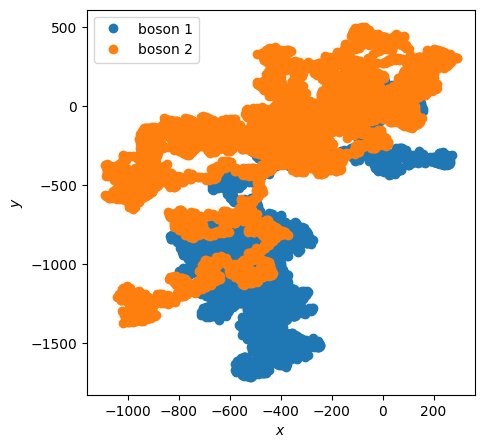

In [51]:
samples = rbm.generate_samples(n_samples=10000, gibbs_steps=100)

# Plot the samples
plt.figure(figsize=(5, 5))
plt.plot(samples[:, 0, 0], samples[:, 0, 1], 'o', label='boson 1')
plt.plot(samples[:, 1, 0], samples[:, 1, 1], 'o', label='boson 2')
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.legend()

In [52]:
# Define the discriminator model: this can be a simple feed-forward neural network
import torch
import torch.nn as nn

class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 64),
            nn.LeakyReLU(0.2),
            nn.Linear(64, 1),
            nn.Sigmoid() # Sigmoid since we're doing binary classification
        )
    
    def forward(self, x):
        output = self.model(x)
        return output

def build_discriminator():
    # model will be a simple FFNN
    model = Discriminator(input_dim=2)
    criterion = nn.BCELoss() # Binary cross entropy loss since we're doing binary classification
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0002) # Using Adam optimizer as mentioned in the paper


    return model

# Use the existing RBM as the generator
def build_generator():
    rbm_true = init_rbm(2,2,2,0)
    rbm_fake = init_rbm(2,2,2,1)

    
    model = ... # This would be your RBM model
    return model

# Combined network
def build_gan(generator, discriminator):
    discriminator.trainable = False
    model = ... # Combined model where the generator produces a state and the discriminator evaluates it
    model.compile(loss='binary_crossentropy', optimizer=...)
    return model

# Instantiate the models
discriminator = build_discriminator()
generator = build_generator()
gan = build_gan(generator, discriminator)


NameError: name 'init_rbm' is not defined

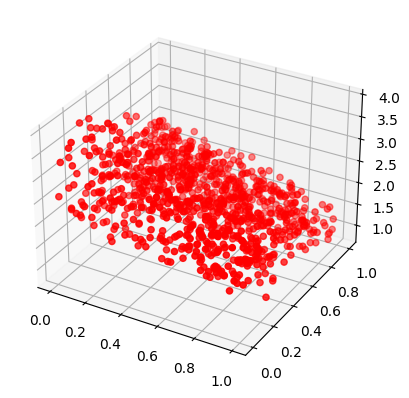

In [15]:
NumberParticles = 2
Dimension = 2
coordinates = []
rbm_generations = []
for i in range(1000):
    coordinates.append(np.random.uniform(-30,30,(NumberParticles,Dimension)))
    rbm_generations.append(rbm(coordinates[i],a,b,w))

# 3d plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x = [coordinates[i][0,0] for i in range(len(coordinates))]
y = [coordinates[i][0,1] for i in range(len(coordinates))]
z = [rbm_generations[i] for i in range(len(coordinates))]
ax.scatter(x, y, z, c='r', marker='o')
plt.show()